<a href="https://colab.research.google.com/github/Iktaik-Kim/MCP/blob/main/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 기본 강화학습 주식 트레이딩 시스템 시작
🎯 기본 강화학습 주식 트레이딩 시스템
📊 샘플 주가 데이터 생성 중...
✅ 샘플 데이터 생성 완료: 480일치
✅ 거래 환경 생성 완료
   - 상태 차원: 8
   - 행동 공간: [0, 1, 2]
   - 데이터 기간: 480일
✅ DQN 에이전트 생성 완료
🧠 에이전트 학습 시작...
Episode 10/50, Avg Reward: 0.0231, Avg Portfolio: 10,096,109원, Epsilon: 0.010
Episode 20/50, Avg Reward: 0.1862, Avg Portfolio: 11,766,732원, Epsilon: 0.010
Episode 30/50, Avg Reward: 0.1710, Avg Portfolio: 11,585,963원, Epsilon: 0.010
Episode 40/50, Avg Reward: 0.1832, Avg Portfolio: 11,767,682원, Epsilon: 0.010
Episode 50/50, Avg Reward: 0.1932, Avg Portfolio: 11,800,181원, Epsilon: 0.010
✅ 학습 완료!

📈 에이전트 평가 중...
초기 자산: 10,000,000원
최종 자산: 9,975,869원
총 수익률: -0.24%
행동 분포 - 매수: 1, 매도: 476, 홀드: 2

🔍 Buy & Hold 전략 비교...
Buy & Hold 최종 자산: 13,663,030원
Buy & Hold 수익률: 36.63%


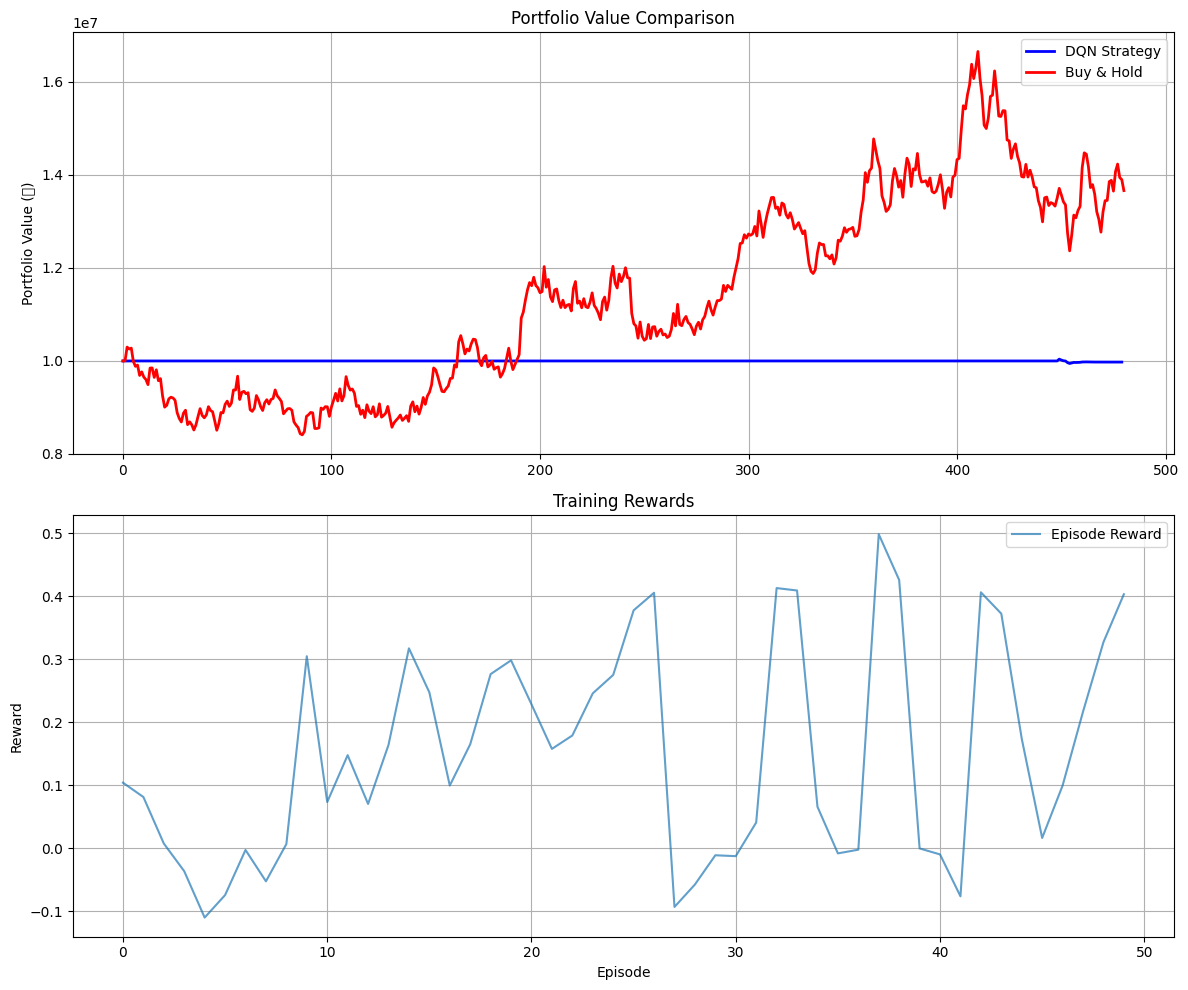


📊 최종 결과 비교
전략              최종자산            수익률       
----------------------------------------
DQN             9,975,869       -0.24     %
Buy & Hold      13,663,030      36.63     %
📉 Buy & Hold 전략이 더 좋은 성과를 달성했습니다.
🏁 프로그램 종료


In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

print("🚀 기본 강화학습 주식 트레이딩 시스템 시작")

# =============================================================================
# 1. 샘플 데이터 생성 (실제 데이터가 없는 경우)
# =============================================================================
def create_sample_stock_data(days=1000, start_price=10000):
    """랜덤 워크를 이용한 샘플 주가 데이터 생성"""
    print("📊 샘플 주가 데이터 생성 중...")

    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', periods=days, freq='D')

    # 랜덤 워크로 주가 생성
    returns = np.random.normal(0.0005, 0.02, days)  # 평균 0.05%, 표준편차 2%
    prices = [start_price]

    for ret in returns:
        new_price = prices[-1] * (1 + ret)
        prices.append(new_price)

    prices = prices[:days]  # 길이 맞추기

    # 고가, 저가, 종가, 거래량 생성
    df = pd.DataFrame({
        'date': dates,
        'high': [p * (1 + abs(np.random.normal(0, 0.01))) for p in prices],  # 고가
        'low': [p * (1 - abs(np.random.normal(0, 0.01))) for p in prices],   # 저가
        'close': prices,  # 종가
        'volume': np.random.randint(1000000, 5000000, days)  # 거래량
    })

    # 간단한 기술적 지표 추가
    df['MA_5'] = df['close'].rolling(5).mean()
    df['MA_20'] = df['close'].rolling(20).mean()
    df['daily_return'] = df['close'].pct_change()
    df['volatility'] = df['daily_return'].rolling(20).std()

    # NaN 값 제거
    df = df.dropna().reset_index(drop=True)

    print(f"✅ 샘플 데이터 생성 완료: {len(df)}일치")
    return df

# =============================================================================
# 2. 주식 거래 환경
# =============================================================================
class SimpleStockTradingEnv:
    def __init__(self, df, initial_balance=10000000):
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.current_step = 0
        self.max_steps = len(df) - 1

        # 계정 상태
        self.balance = initial_balance
        self.shares_held = 0
        self.total_assets = initial_balance

        # 액션 공간
        self.action_space = [0, 1, 2]  # 매수, 매도, 홀드

        # 상태 공간 크기
        self.state_features = ['close', 'MA_5', 'MA_20', 'daily_return', 'volatility', 'volume']
        self.n_features = len(self.state_features) + 2  # + 보유주식, 현금비율

    def reset(self):
        """환경 초기화"""
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_assets = self.initial_balance
        return self._get_state()

    def _get_state(self):
        """현재 상태 반환"""
        if self.current_step >= len(self.df):
            return np.zeros(self.n_features)

        current_data = self.df.iloc[self.current_step]
        state = []

        # 가격 및 기술적 지표
        for feature in self.state_features:
            value = current_data[feature]
            # 간단한 정규화
            if feature == 'volume':
                value = value / 1000000  # 백만 단위로 정규화
            elif feature in ['daily_return', 'volatility']:
                value = value * 100  # 퍼센트로 변환
            state.append(value)

        # 계정 상태 (정규화)
        state.append(self.shares_held / 100)  # 보유 주식 수
        state.append(self.balance / self.initial_balance)  # 현금 비율

        return np.array(state, dtype=np.float32)

    def step(self, action):
        """행동 수행"""
        if self.current_step >= self.max_steps:
            # 에피소드 종료
            return self._get_state(), 0, True, {}

        current_price = self.df.iloc[self.current_step]['close']
        prev_total_assets = self.total_assets

        # 행동 수행
        if action == 0:  # 매수
            self._execute_buy(current_price)
        elif action == 1:  # 매도
            self._execute_sell(current_price)
        # action == 2: 홀드 (아무 행동 안 함)

        # 포트폴리오 가치 업데이트
        self.total_assets = self.balance + (self.shares_held * current_price)

        # 보상 계산 (포트폴리오 가치 변화)
        reward = (self.total_assets - prev_total_assets) / prev_total_assets

        # 다음 스텝으로 이동
        self.current_step += 1

        # 에피소드 종료 확인
        done = self.current_step >= self.max_steps

        # 정보
        info = {
            'step': self.current_step,
            'balance': self.balance,
            'shares': self.shares_held,
            'total_assets': self.total_assets,
            'price': current_price
        }

        next_state = self._get_state()
        return next_state, reward, done, info

    def _execute_buy(self, price):
        """매수 실행"""
        if price <= 0:
            return

        # 25% 현금으로 매수
        buy_amount = self.balance * 0.25
        shares_to_buy = int(buy_amount / price)

        if shares_to_buy > 0:
            self.shares_held += shares_to_buy
            self.balance -= shares_to_buy * price

    def _execute_sell(self, price):
        """매도 실행"""
        if self.shares_held == 0 or price <= 0:
            return

        # 25% 주식 매도
        shares_to_sell = max(1, int(self.shares_held * 0.25))
        shares_to_sell = min(shares_to_sell, self.shares_held)

        self.shares_held -= shares_to_sell
        self.balance += shares_to_sell * price

    def render(self):
        """현재 상태 출력"""
        if self.current_step < len(self.df):
            current_data = self.df.iloc[self.current_step]
            print(f"Step: {self.current_step}, Date: {current_data['date'].strftime('%Y-%m-%d')}")
            print(f"Price: {current_data['close']:,.0f}원, Shares: {self.shares_held}, Balance: {self.balance:,.0f}원")
            print(f"Total Assets: {self.total_assets:,.0f}원")
            print("-" * 50)

# =============================================================================
# 3. 간단한 신경망
# =============================================================================
class SimpleQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(SimpleQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# =============================================================================
# 4. DQN 에이전트
# =============================================================================
class SimpleDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-Network
        self.q_network = SimpleQNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)

        # 학습 파라미터
        self.gamma = 0.95  # 할인계수
        self.epsilon = 1.0  # 탐험률
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 32

        # 경험 재생 버퍼
        self.memory = deque(maxlen=2000)

    def remember(self, state, action, reward, next_state, done):
        """경험 저장"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """행동 선택"""
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)  # 탐험

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.q_network(state)
        return np.argmax(q_values.cpu().data.numpy())  # 활용

    def replay(self):
        """경험 재생으로 학습"""
        if len(self.memory) < self.batch_size:
            return

        # 배치 샘플링
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Tensor 변환
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)

        # 현재 Q 값
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))

        # 다음 Q 값
        next_q = self.q_network(next_states).max(1)[0].detach()
        target_q = rewards + (self.gamma * next_q * ~dones)

        # 손실 계산 및 학습
        loss = nn.MSELoss()(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 탐험률 감소
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

# =============================================================================
# 5. 학습 함수
# =============================================================================
def train_agent(env, agent, episodes=100):
    """에이전트 학습"""
    print("🧠 에이전트 학습 시작...")

    rewards_history = []
    portfolio_history = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_portfolio = []

        while True:
            # 행동 선택 및 실행
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)

            # 경험 저장
            agent.remember(state, action, reward, next_state, done)

            # 학습
            loss = agent.replay()

            total_reward += reward
            episode_portfolio.append(info['total_assets'])
            state = next_state

            if done:
                break

        rewards_history.append(total_reward)
        final_portfolio = episode_portfolio[-1] if episode_portfolio else env.initial_balance
        portfolio_history.append(final_portfolio)

        # 진행 상황 출력
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(rewards_history[-10:])
            avg_portfolio = np.mean(portfolio_history[-10:])
            print(f"Episode {episode+1}/{episodes}, "
                  f"Avg Reward: {avg_reward:.4f}, "
                  f"Avg Portfolio: {avg_portfolio:,.0f}원, "
                  f"Epsilon: {agent.epsilon:.3f}")

    print("✅ 학습 완료!")
    return rewards_history, portfolio_history

# =============================================================================
# 6. 평가 함수
# =============================================================================
def evaluate_agent(env, agent):
    """학습된 에이전트 평가"""
    print("\n📈 에이전트 평가 중...")

    state = env.reset()
    portfolio_values = [env.initial_balance]
    actions_taken = []

    while True:
        # 탐험 없이 행동 선택
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)

        portfolio_values.append(info['total_assets'])
        actions_taken.append(action)
        state = next_state

        if done:
            break

    # 최종 결과
    initial = env.initial_balance
    final = portfolio_values[-1]
    total_return = (final - initial) / initial * 100

    print(f"초기 자산: {initial:,.0f}원")
    print(f"최종 자산: {final:,.0f}원")
    print(f"총 수익률: {total_return:.2f}%")
    print(f"행동 분포 - 매수: {actions_taken.count(0)}, 매도: {actions_taken.count(1)}, 홀드: {actions_taken.count(2)}")

    return portfolio_values, actions_taken

def buy_and_hold(env):
    """Buy & Hold 전략"""
    print("\n🔍 Buy & Hold 전략 비교...")

    env.reset()
    portfolio_values = [env.initial_balance]
    initial_price = env.df.iloc[0]['close']

    for step in range(len(env.df)):
        current_price = env.df.iloc[step]['close']
        # 처음에 전량 매수
        shares = env.initial_balance // initial_price
        cash = env.initial_balance - (shares * initial_price)
        portfolio_value = cash + (shares * current_price)
        portfolio_values.append(portfolio_value)

    final = portfolio_values[-1]
    total_return = (final - env.initial_balance) / env.initial_balance * 100

    print(f"Buy & Hold 최종 자산: {final:,.0f}원")
    print(f"Buy & Hold 수익률: {total_return:.2f}%")

    return portfolio_values

# =============================================================================
# 7. 결과 시각화
# =============================================================================
def plot_results(dqn_values, bh_values, rewards):
    """결과 시각화"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # 포트폴리오 가치 비교
    ax1.plot(dqn_values, label='DQN Strategy', linewidth=2, color='blue')
    ax1.plot(bh_values, label='Buy & Hold', linewidth=2, color='red')
    ax1.set_title('Portfolio Value Comparison')
    ax1.set_ylabel('Portfolio Value (원)')
    ax1.legend()
    ax1.grid(True)

    # 학습 과정 (보상)
    ax2.plot(rewards, label='Episode Reward', alpha=0.7)
    ax2.set_title('Training Rewards')
    ax2.set_ylabel('Reward')
    ax2.set_xlabel('Episode')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 메인 실행 함수
# =============================================================================
def main():
    """메인 실행 함수"""
    print("=" * 60)
    print("🎯 기본 강화학습 주식 트레이딩 시스템")
    print("=" * 60)

    # 1. 데이터 생성
    df = create_sample_stock_data(days=500)

    # 2. 환경 생성
    env = SimpleStockTradingEnv(df)
    print(f"✅ 거래 환경 생성 완료")
    print(f"   - 상태 차원: {env.n_features}")
    print(f"   - 행동 공간: {env.action_space}")
    print(f"   - 데이터 기간: {len(df)}일")

    # 3. 에이전트 생성
    agent = SimpleDQNAgent(env.n_features, len(env.action_space))
    print(f"✅ DQN 에이전트 생성 완료")

    # 4. 학습
    rewards, portfolios = train_agent(env, agent, episodes=50)

    # 5. 평가
    dqn_portfolio, dqn_actions = evaluate_agent(env, agent)
    bh_portfolio = buy_and_hold(env)

    # 6. 결과 시각화
    plot_results(dqn_portfolio, bh_portfolio, rewards)

    # 7. 최종 비교
    dqn_return = (dqn_portfolio[-1] - env.initial_balance) / env.initial_balance * 100
    bh_return = (bh_portfolio[-1] - env.initial_balance) / env.initial_balance * 100

    print("\n" + "=" * 60)
    print("📊 최종 결과 비교")
    print("=" * 60)
    print(f"{'전략':<15} {'최종자산':<15} {'수익률':<10}")
    print(f"{'-' * 40}")
    print(f"{'DQN':<15} {dqn_portfolio[-1]:<15,.0f} {dqn_return:<10.2f}%")
    print(f"{'Buy & Hold':<15} {bh_portfolio[-1]:<15,.0f} {bh_return:<10.2f}%")

    if dqn_return > bh_return:
        print("🎉 DQN 전략이 더 좋은 성과를 달성했습니다!")
    else:
        print("📉 Buy & Hold 전략이 더 좋은 성과를 달성했습니다.")

    print("=" * 60)

# =============================================================================
# 프로그램 시작
# =============================================================================
if __name__ == "__main__":
    # 예외 처리
    try:
        main()
    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        import traceback
        traceback.print_exc()

    print("🏁 프로그램 종료")